In [1]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing import image

import numpy as np
import scipy

from matplotlib import pyplot as plt

import tensorflow as tf


tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
model.summary()
# plot_model(model, to_file='./graphical_description/deep_dream_incenptionV3.png', show_shapes=True)

/opt/homebrew/Caskroom/miniforge/base/envs/tf26/lib/python3.9/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-24 21:49:32.964963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 21:49:32.965080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-24 21:49:33.039115: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 21:49:33.039577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 21:49:33.178893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 21:49:33.713986: I tensorflow/core/grappler/o

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [4]:
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [5]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
step = 0.01
num_octave = 3 
octave_scale = 1.4
iterations = 20 

max_loss = 10.

base_image_path = './datasets/original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='./datasets/dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./datasets/final_dream.png')

처리할 이미지 크기 (178, 178)


2022-07-24 21:49:34.279856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 21:49:34.337433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-24 21:49:34.351810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... 0 번째 손실 : 0.6718055
... 1 번째 손실 : 1.0313525
... 2 번째 손실 : 1.4851838
... 3 번째 손실 : 2.0245302
... 4 번째 손실 : 2.6349785
... 5 번째 손실 : 3.1217618
... 6 번째 손실 : 3.601147
... 7 번째 손실 : 4.09599
... 8 번째 손실 : 4.49925
... 9 번째 손실 : 4.9115553
... 10 번째 손실 : 5.3172398
... 11 번째 손실 : 5.6997867
... 12 번째 손실 : 6.187613
... 13 번째 손실 : 6.555364
... 14 번째 손실 : 6.933248
... 15 번째 손실 : 7.23725
... 16 번째 손실 : 7.6665
... 17 번째 손실 : 8.058625
... 18 번째 손실 : 8.419688
... 19 번째 손실 : 8.874386
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.167194
... 1 번째 손실 : 3.5432327
... 2 번째 손실 : 4.671268
... 3 번째 손실 : 5.6158834
... 4 번째 손실 : 6.4941015
... 5 번째 손실 : 7.2943916
... 6 번째 손실 : 8.025548
... 7 번째 손실 : 8.725782
... 8 번째 손실 : 9.335506
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.3286862
... 1 번째 손실 : 3.5874982
... 2 번째 손실 : 4.8022604
... 3 번째 손실 : 5.9655323
... 4 번째 손실 : 7.297114
... 5 번째 손실 : 9.062135


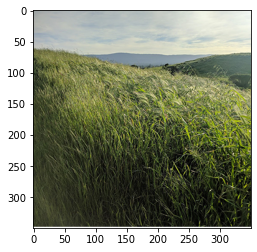

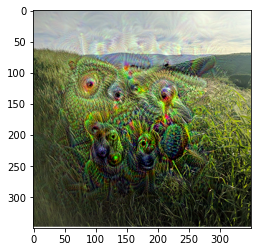

In [7]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()